In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [3]:
file_path = '/content/SONY.csv'

# Đọc dữ liệu từ file CSV
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

In [4]:
df

,Close,Open,High,Low
Date,,,,
2019-03-01,47.89,47.82,48.06,47.69
2019-03-04,47.62,47.78,47.87,47.23
2019-03-05,47.66,47.75,47.90,47.53
2019-03-06,47.53,47.68,47.81,47.52
2019-03-07,46.40,47.00,47.00,46.14
...,...,...,...,...
2024-05-20,83.59,83.75,84.00,83.50
2024-05-21,82.00,82.81,82.81,81.97
2024-05-22,81.26,81.73,81.81,81.18


In [5]:
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [6]:
# Định nghĩa hàm kiểm tra tính dừng
def check_stationarity(data):
    for col in data.columns:
        result = adfuller(data[col])
        print(f'Kiểm tra tính dừng cho cột {col}:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print(f'==> {"Không phải" if result[1] > 0.05 else "Là"} chuỗi dừng\n')

# Gọi hàm kiểm tra tính dừng với DataFrame của bạn
check_stationarity(df)

Kiểm tra tính dừng cho cột Close:
ADF Statistic: -2.1977952219382466
p-value: 0.20704663709274118
Critical Values:
   1%: -3.4353516488758684
   5%: -2.8637488209107196
   10%: -2.5679459879960373
==> Không phải chuỗi dừng

Kiểm tra tính dừng cho cột Open:
ADF Statistic: -2.206564136749211
p-value: 0.2038716859863181
Critical Values:
   1%: -3.4353440094155756
   5%: -2.8637454499962196
   10%: -2.5679441928400135
==> Không phải chuỗi dừng

Kiểm tra tính dừng cho cột High:
ADF Statistic: -2.1961831150475484
p-value: 0.20763368145536742
Critical Values:
   1%: -3.4353440094155756
   5%: -2.8637454499962196
   10%: -2.5679441928400135
==> Không phải chuỗi dừng

Kiểm tra tính dừng cho cột Low:
ADF Statistic: -2.0946238929878205
p-value: 0.24668184909442797
Critical Values:
   1%: -3.435325012475485
   5%: -2.8637370675527087
   10%: -2.567939728836562
==> Không phải chuỗi dừng



In [7]:
from sklearn.model_selection import train_test_split

# chia bộ dữ liệu theo tỉ lệ 8:2
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# dùng diff để chuyển đổi bộ dữ liệu
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [8]:
# Định nghĩa hàm kiểm tra tính dừng
def check_stationarity(data):
    for col in data.columns:
        result = adfuller(data[col])
        print(f'Kiểm tra tính dừng cho cột {col}:')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print(f'==> {"Không phải" if result[1] > 0.05 else "Là"} chuỗi dừng\n')

# Gọi hàm kiểm tra tính dừng với DataFrame của bạn
check_stationarity(train_diff)

Kiểm tra tính dừng cho cột Close:
ADF Statistic: -10.403618193542735
p-value: 1.881441043829811e-18
Critical Values:
   1%: -3.436617132314828
   5%: -2.864307097893787
   10%: -2.568243313067353
==> Là chuỗi dừng

Kiểm tra tính dừng cho cột Open:
ADF Statistic: -8.6271594710913
p-value: 5.887862125861997e-14
Critical Values:
   1%: -3.436659460539809
   5%: -2.864325767240336
   10%: -2.5682532565554537
==> Là chuỗi dừng

Kiểm tra tính dừng cho cột High:
ADF Statistic: -11.92000430034246
p-value: 5.058391449535727e-22
Critical Values:
   1%: -3.436605142651622
   5%: -2.8643018096684587
   10%: -2.568240496510984
==> Là chuỗi dừng

Kiểm tra tính dừng cho cột Low:
ADF Statistic: -29.32361639736249
p-value: 0.0
Critical Values:
   1%: -3.4365753682419133
   5%: -2.8642886771163396
   10%: -2.568233502009814
==> Là chuỗi dừng



In [9]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00


In [10]:
from pmdarima import auto_arima
import pandas as pd
pq = []
for column in train_diff:
    print(f'Searching order of p and q for : {column}')
    stepwise_model = auto_arima(train_diff[column],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{column} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Close
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3971.038, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3969.595, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3970.149, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3970.280, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3970.849, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.704 seconds
optimal order for:Close is: (0, 0, 0) 


Searching order of p and q for : Open
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3901.702, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3898.882, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3900.530, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3900.554, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3900.088, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit ti

In [2]:
# vẽ biểu đồ PACF
# for col in df.columns:
#     plt.figure(figsize=(20, 6))
#     plot_pacf(df[col], lags=40)  # Thay 'Your_Column_Name' bằng tên cột của bạn
#     plt.xlabel('Lags')
#     plt.ylabel('PACF')
#     plt.title(f'Partial Autocorrelation Function (PACF) "{col}"')
#     plt.grid(True)
#     plt.show()

In [1]:
# vẽ biểu đồ ACF
# for col in df.columns:
#     plt.figure(figsize=(20, 6))
#     plot_acf(df[col], lags=40)  # Thay 'Your_Column_Name' bằng tên cột của bạn
#     plt.xlabel('Lags')
#     plt.ylabel('ACF')
#     plt.title(f'Partial Autocorrelation Function (ACF) "{col}"')
#     plt.grid(True)
#     plt.show()

In [11]:

model = VARMAX(train_diff, order=(1, 0))
results = model.fit()

print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                  Statespace Model Results                                  
Dep. Variable:     ['Close', 'Open', 'High', 'Low']   No. Observations:                 1054
Model:                                       VAR(1)   Log Likelihood               -4682.921
                                        + intercept   AIC                           9425.843
Date:                              Sun, 02 Jun 2024   BIC                           9574.653
Time:                                      08:53:40   HQIC                          9482.257
Sample:                                           0                                         
                                             - 1054                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):     0.00, 62.09, 21.77, 23.26   Jarque-Bera (JB):   1188.84, 1165.38, 856.95, 483.44
Prob(Q):                   0.98, 0.00, 0.00, 0.00   Prob(J

In [12]:
predict = results.get_prediction(start = len(train), end = len(train) + len(test) - 1)
predicts = predict.predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [13]:
predicts.columns = ['Open_predicted', 'High_predicted', 'Low_predicted', 'Close_predicted']
predicts['Date'] = test.index
predicts
predicts_date = predicts.set_index('Date')
predicts_date

,Open_predicted,High_predicted,Low_predicted,Close_predicted
Date,,,,
2023-05-09,0.024506,0.252360,0.017890,0.161421
2023-05-10,0.052325,-0.024169,0.075011,0.004209
2023-05-11,0.035507,0.061610,0.017877,0.052666
2023-05-12,0.046249,0.035353,0.056510,0.038217
2023-05-15,0.040029,0.043872,0.034147,0.042852
...,...,...,...,...
2024-05-20,0.042244,0.041683,0.042069,0.041646
2024-05-21,0.042244,0.041683,0.042069,0.041646
2024-05-22,0.042244,0.041683,0.042069,0.041646


In [19]:
# Lấy giá trị cuối cùng của dữ liệu gốc trước khi diff
last_original_values = df.iloc[len(train)-1]

train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Lấy giá trị cuối cùng của dữ liệu gốc trước khi diff
last_original_values = df.iloc[-len(test) - 1]
# Tạo một DataFrame để chứa các giá trị dự đoán gốc
forecast_original_data = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close'], index=test.index)

# Khởi tạo giá trị bắt đầu với giá trị cuối cùng của dữ liệu gốc
current_values = last_original_values.copy()

# Thực hiện inverse differencing cho từng ngày dự đoán
for index, row in predicts_date.iterrows():
    current_values['Open'] += row['Open_predicted']
    current_values['High'] += row['High_predicted']
    current_values['Low'] += row['Low_predicted']
    current_values['Close'] += row['Close_predicted']
    # Thêm giá trị hiện tại vào DataFrame kết quả
    forecast_original_data.loc[index] = current_values

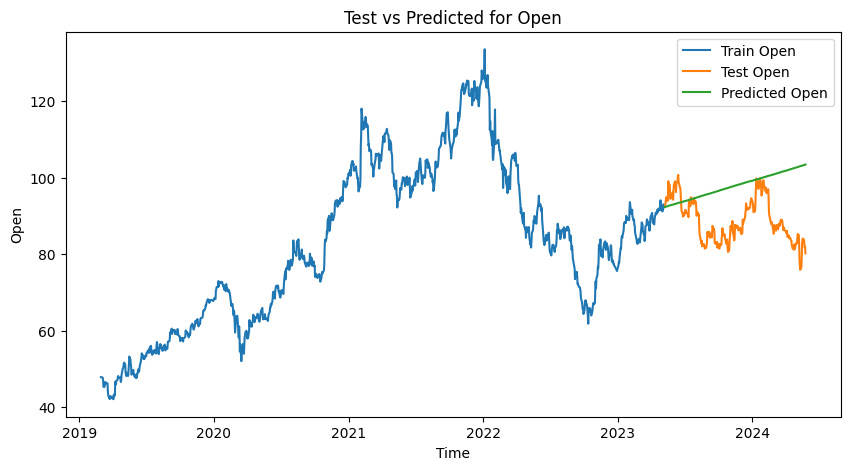

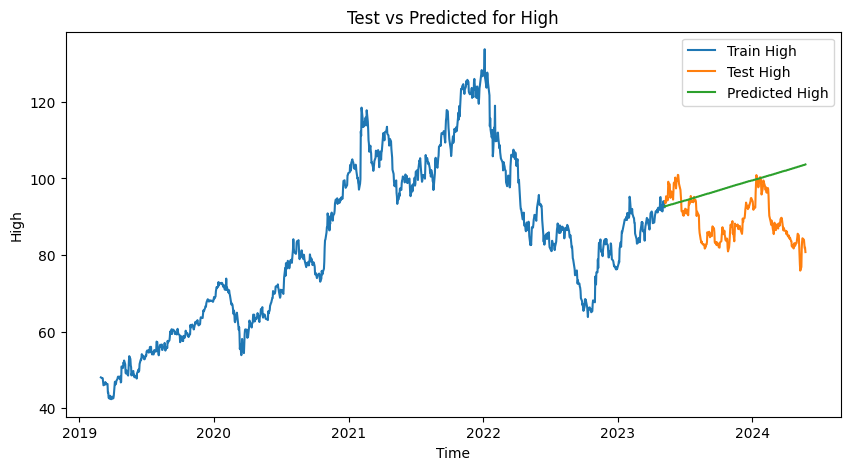

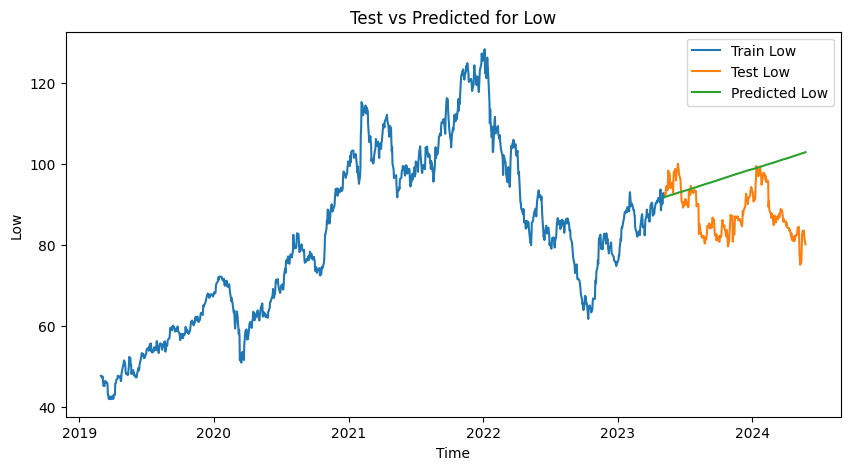

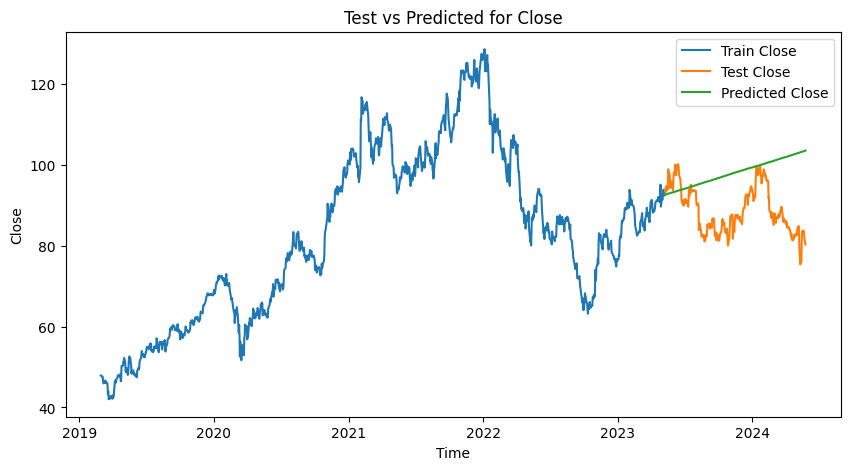

In [21]:
# Vẽ biểu đồ cho mỗi cặp cột
for col in ['Open', 'High', 'Low', 'Close']:
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train[col], label=f'Train {col}')
    plt.plot(test.index, test[col], label=f'Test {col}')
    plt.plot(forecast_original_data.index, forecast_original_data[col], label=f'Predicted {col}')
    plt.title(f'Test vs Predicted for {col}')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [24]:


# Tính toán MAPE và RMSE
mape = mean_absolute_percentage_error(test, predicts_date)
rmse = np.sqrt(mean_squared_error(test, predicts_date))
mse = mean_squared_error(test, predicts_date)
r2 = r2_score(test, predicts_date)

print(f'MAPE: {mape:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')

results_GBM = pd.DataFrame([['Gradient Boosting', mape, mse, rmse, r2]],
               columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])
results_GBM

MAPE: 0.9995
RMSE: 88.8179
MSE: 7888.6257
R²: -247.4490


,Model,MAE,MSE,RMSE,R2 Score
0,Gradient Boosting,0.999523,7888.625667,88.817936,-247.449022
